In [2]:
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForMaskedLM, Trainer, TrainingArguments
import torch
import pandas as pd

In [3]:
# Consider using RoBERTa

In [5]:
# model_name = "distilbert-base-uncased"  # Standard DistilBERT model
# tokenizer = DistilBertTokenizer.from_pretrained(model_name)
# model = DistilBertModel.from_pretrained(model_name)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased')

dtype = None
model = model.to(dtype).to('cuda')

## Load Dataset

In [6]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [7]:
from datasets import load_dataset
dataset = load_dataset("code_search_net", "python", trust_remote_code=True)
# print and see dataset
dataset

README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

code_search_net.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

python.zip:   0%|          | 0.00/941M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 412178
    })
    test: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 22176
    })
    validation: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 23107
    })
})

## Formatting the Input

Considerations:

1. func_code_string contains the comment as far as i know - consider methods to remove that. - **DONE**
2. Explore dataset for function documentation and inline comments. - **DONE: No inline comments**
3. func_name required? Removed for now because func_code_string already contains name of function. However, func_name may have more data like class name. Might be beneficial to add?

In [144]:
import re

# With Batching

# def remove_comments(batch):
#     # The function now processes a batch of code strings
#     cleaned_code_strings = []
#     for code_string in batch['func_code_string']:
#         # Remove single-line comments
#         code = re.sub(r"#.*", "", code_string)
#         # Remove multi-line comments (both """ and ''')
#         code = re.sub(r"'''(.*?)'''", "", code, flags=re.DOTALL)
#         code = re.sub(r'"""(.*?)"""', "", code, flags=re.DOTALL)
#         cleaned_code_strings.append(code.strip())

#     # Update the batch with cleaned code strings
#     batch['func_code_string'] = cleaned_code_strings
#     return batch

def mask_comments(batch):
    # The function now processes a batch of code strings to mask comments
    masked_code_strings = []
    for code_string in batch['func_code_string']:
        # Remove single-line comments
        code = re.sub(r"#.*", "", code_string)
        # Mask multi-line comments (both """ and ''')
        code = re.sub(r"'''(.*?)'''", "[MASK]", code, flags=re.DOTALL)
        code = re.sub(r'"""(.*?)"""', "[MASK]", code, flags=re.DOTALL)
        masked_code_strings.append(code.strip())

    # Update the batch with masked code strings
    batch['func_code_string'] = masked_code_strings
    return batch

In [145]:
# With Batching

def preprocess_function(examples):
    contextual_inputs = [
        f"{repo} {path} <sep> {code}"
        for repo, path, code in zip(
            examples['repository_name'],
            examples['func_path_in_repository'],
            examples['func_code_string']
        )
    ]

    inputs = tokenizer(contextual_inputs, truncation=True, padding="max_length", max_length=256)
    outputs = tokenizer(examples["func_documentation_string"], truncation=True, padding="max_length", max_length=256)

    inputs['labels'] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in label_list]
        for label_list in outputs['input_ids']
    ]

    return inputs

In [153]:
# tokenized_dataset = dataset.map(preprocess_function, batched=True)

# train_subset = dataset['train'].select(range(10))
dataset_with_masks = dataset.map(mask_comments, batched=True)
tokenized_dataset = dataset_with_masks.map(preprocess_function, batched=True)


Map:   0%|          | 0/412178 [00:00<?, ? examples/s]

Map:   0%|          | 0/22176 [00:00<?, ? examples/s]

Map:   0%|          | 0/23107 [00:00<?, ? examples/s]

In [157]:
print(tokenized_dataset['train'][0])

{'repository_name': 'adamrehn/ue4cli', 'func_path_in_repository': 'ue4cli/Utility.py', 'func_name': 'Utility.findArgs', 'whole_func_string': 'def findArgs(args, prefixes):\n\t\t"""\n\t\tExtracts the list of arguments that start with any of the specified prefix values\n\t\t"""\n\t\treturn list([\n\t\t\targ for arg in args\n\t\t\tif len([p for p in prefixes if arg.lower().startswith(p.lower())]) > 0\n\t\t])', 'language': 'python', 'func_code_string': 'def findArgs(args, prefixes):\n\t\t[MASK]\n\t\treturn list([\n\t\t\targ for arg in args\n\t\t\tif len([p for p in prefixes if arg.lower().startswith(p.lower())]) > 0\n\t\t])', 'func_code_tokens': ['def', 'findArgs', '(', 'args', ',', 'prefixes', ')', ':', 'return', 'list', '(', '[', 'arg', 'for', 'arg', 'in', 'args', 'if', 'len', '(', '[', 'p', 'for', 'p', 'in', 'prefixes', 'if', 'arg', '.', 'lower', '(', ')', '.', 'startswith', '(', 'p', '.', 'lower', '(', ')', ')', ']', ')', '>', '0', ']', ')'], 'func_documentation_string': 'Extracts the 

In [160]:
print(tokenized_dataset['train'][0]['func_code_string'])

def findArgs(args, prefixes):
		[MASK]
		return list([
			arg for arg in args
			if len([p for p in prefixes if arg.lower().startswith(p.lower())]) > 0
		])


In [162]:
print(tokenized_dataset['train'][0]['func_documentation_string'])

Extracts the list of arguments that start with any of the specified prefix values


## Training

In [165]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps = 1,
    num_train_epochs=1,
    # max_steps=1000,
    weight_decay=0.03,
    warmup_steps=200,
    lr_scheduler_type = "cosine_with_restarts",
    logging_dir='./logs',
    logging_steps=500,
    report_to = "none",
    eval_strategy="steps",
    eval_steps=500,
    save_steps=2000,
    save_total_limit=5,
    metric_for_best_model="eval_loss",
    optim = "adamw_hf",
    load_best_model_at_end=True,
    greater_is_better=False,
    seed=3407,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation']
)

In [166]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,4.808800,5.474384
1000,4.961300,5.423180
1500,5.132300,5.395232
2000,5.210800,5.386659
2500,5.181600,5.376936
3000,5.169000,5.382838
3500,5.157800,5.378870
4000,5.143800,5.369066
4500,5.129900,5.377895
5000,5.165700,5.363622


There were missing keys in the checkpoint model loaded: ['vocab_projector.weight'].


TrainOutput(global_step=25762, training_loss=5.1039000929406075, metrics={'train_runtime': 3376.8674, 'train_samples_per_second': 122.059, 'train_steps_per_second': 7.629, 'total_flos': 2.7319396098668544e+16, 'train_loss': 5.1039000929406075, 'epoch': 1.0})

## Save Checkpoint to Drive

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
import os
import shutil

source_folder = '/content/results'
destination_folder = '/content/drive/My Drive/DL/finalproj/checkpoints'

os.makedirs(destination_folder, exist_ok=True)

In [169]:
# Copy files from source to destination
if os.path.exists(source_folder):
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
else:
    print(f"Source folder {source_folder} does not exist. Please check the source path.")

## Save model to drive

In [212]:
model.save_pretrained("best_model/distilbert_documentation_model_python_1epoch")
tokenizer.save_pretrained("best_model/distilbert_documentation_model_python_1epoch")

('best_model/distilbert_documentation_model_python_1epoch/tokenizer_config.json',
 'best_model/distilbert_documentation_model_python_1epoch/special_tokens_map.json',
 'best_model/distilbert_documentation_model_python_1epoch/vocab.txt',
 'best_model/distilbert_documentation_model_python_1epoch/added_tokens.json')

In [213]:
source_folder = '/content/best_model/distilbert_documentation_model_python_1epoch'
destination_folder = '/content/drive/My Drive/DL/finalproj/checkpoints/best_model_python_1epoch'

os.makedirs(destination_folder, exist_ok=True)

In [214]:
import os
import shutil

if os.path.exists(source_folder):
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
else:
    print(f"Source folder {source_folder} does not exist. Please check the source path.")


## Sanity Check

In [170]:
test_dataset = tokenized_dataset['test']

input = test_dataset['func_code_string'][0]
print("Input: ", input)

expected_output = test_dataset['func_documentation_string'][0]
print("\nExpected Output: ", expected_output)


Input:  def get_vid_from_url(url):
        [MASK]
        return match1(url, r'youtu\.be/([^?/]+)') or \
          match1(url, r'youtube\.com/embed/([^/?]+)') or \
          match1(url, r'youtube\.com/v/([^/?]+)') or \
          match1(url, r'youtube\.com/watch/([^/?]+)') or \
          parse_query_param(url, 'v') or \
          parse_query_param(parse_query_param(url, 'u'), 'v')

Expected Output:  Extracts video ID from URL.


In [174]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0

### Inference on One point

In [176]:
def get_code_predictions(code_snippets):
    inputs = tokenizer(code_snippets, padding=True, truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = outputs.logits

    decoded_predictions = []
    for i in range(predictions.shape[0]):
        mask_token_index = (input_ids[i] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0]
        for idx in mask_token_index:
            predicted_token_id = torch.argmax(predictions[i, idx]).item()
            predicted_token = tokenizer.decode([predicted_token_id])
            decoded_predictions.append(predicted_token)

    return decoded_predictions

predicted_tokens = get_code_predictions([input])
for snippet, token, exp_output in zip([input], predicted_tokens, [expected_output]):
    print(f"Code Snippet: {snippet}\nPredicted Comment: {token}\nActualComment: {exp_output}")

Code Snippet: def get_vid_from_url(url):
        [MASK]
        return match1(url, r'youtu\.be/([^?/]+)') or \
          match1(url, r'youtube\.com/embed/([^/?]+)') or \
          match1(url, r'youtube\.com/v/([^/?]+)') or \
          match1(url, r'youtube\.com/watch/([^/?]+)') or \
          parse_query_param(url, 'v') or \
          parse_query_param(parse_query_param(url, 'u'), 'v')
Predicted Comment: ur
ActualComment: Extracts video ID from URL.


## Testing

In [190]:
def clear_cuda():
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.synchronize()

        torch.cuda.reset_peak_memory_stats()
        torch.cuda.reset_accumulated_memory_stats()

        with torch.cuda.device('cuda'):
            torch.cuda.empty_cache()

if torch.cuda.is_available():
    print("Clearing CUDA memory...")
    clear_cuda()
    print("CUDA memory cleared.")

Clearing CUDA memory...
CUDA memory cleared.


In [191]:
batch_size = 30
predicted_comments = []
actual_comments = []
comparison_results = []

for i in range(0, len(dataset['test']['func_code_string']), batch_size):
    print("Batch: ", i, " to ", i + batch_size)
    batch_code_snippets = dataset['test']['func_code_string'][i:i + batch_size]
    batch_actuals = dataset['test']['func_documentation_string'][i:i + batch_size]

    inputs = tokenizer(batch_code_snippets, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")

    with torch.no_grad():
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        predictions = torch.argmax(outputs.logits, dim=-1)

    batch_predictions = [tokenizer.decode(predictions[j], skip_special_tokens=True) for j in range(predictions.size(0))]
    predicted_comments.extend(batch_predictions)

    actual_comments.extend(batch_actuals)

    batch_comparison = [pred.strip().lower() == actual.strip().lower() for pred, actual in zip(batch_predictions, batch_actuals)]
    comparison_results.extend(batch_comparison)

    del inputs
    del outputs
    torch.cuda.empty_cache()
    clear_cuda()

results_df = pd.DataFrame({
    'Predicted Comment': predicted_comments,
    'Actual Comment': actual_comments,
    'Comparison Result': comparison_results
})

print(results_df.head())


Batch:  0  to  30
Batch:  30  to  60
Batch:  60  to  90
Batch:  90  to  120
Batch:  120  to  150
Batch:  150  to  180
Batch:  180  to  210
Batch:  210  to  240
Batch:  240  to  270
Batch:  270  to  300
Batch:  300  to  330
Batch:  330  to  360
Batch:  360  to  390
Batch:  390  to  420
Batch:  420  to  450
Batch:  450  to  480
Batch:  480  to  510
Batch:  510  to  540
Batch:  540  to  570
Batch:  570  to  600
Batch:  600  to  630
Batch:  630  to  660
Batch:  660  to  690
Batch:  690  to  720
Batch:  720  to  750
Batch:  750  to  780
Batch:  780  to  810
Batch:  810  to  840
Batch:  840  to  870
Batch:  870  to  900
Batch:  900  to  930
Batch:  930  to  960
Batch:  960  to  990
Batch:  990  to  1020
Batch:  1020  to  1050
Batch:  1050  to  1080
Batch:  1080  to  1110
Batch:  1110  to  1140
Batch:  1140  to  1170
Batch:  1170  to  1200
Batch:  1200  to  1230
Batch:  1230  to  1260
Batch:  1260  to  1290
Batch:  1290  to  1320
Batch:  1320  to  1350
Batch:  1350  to  1380
Batch:  1380  to 

In [192]:
results_df.head()

,Predicted Comment,Actual Comment,Comparison Result
0,extracts video id from from urll urll url........,Extracts video ID from URL.,False
1,convert a ur ur convert ur convertl urll bi bi...,str->list\n Convert XML to URL List.\n F...,False
2,: : md - -.... -. http / /.......................,From http://cdn37.atwikiimg.com/sitescript/pub...,False
3,wrapperper / / / / /l /. / / / /. / / / / / / ...,wrapper,False
4,downloads dailymotmot..l........ll...............,Downloads Dailymotion videos by URL.,False


In [201]:
clear_cuda()

In [207]:
results_df['Comparison Result'].value_counts()

,count
Comparison Result,
False,22176


## Performance Metrics

In [193]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu_scores(df):
    bleu_scores = []

    for predicted, actual in zip(df['Predicted Comment'], df['Actual Comment']):
        # Tokenize the sentences
        reference = [actual.split()]
        candidate = predicted.split()

        # Calculate BLEU score for 1-gram
        score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))  # This sets up weights for only 1-gram
        bleu_scores.append(score)

    return bleu_scores

results_df['BLEU Score'] = calculate_bleu_scores(results_df)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

                                   Predicted Comment  \
0  extracts video id from from urll urll url........   
1  convert a ur ur convert ur convertl urll bi bi...   
2  : : md - -.... -. http / /.......................   
3  wrapperper / / / / /l /. / / / /. / / / / / / ...   
4  downloads dailymotmot..l........ll...............   

                                      Actual Comment  BLEU Score  
0                        Extracts video ID from URL.    0.025316  
1  str->list\n    Convert XML to URL List.\n    F...    0.000000  
2  From http://cdn37.atwikiimg.com/sitescript/pub...    0.000000  
3                                            wrapper    0.000000  
4               Downloads Dailymotion videos by URL.    0.000000  


In [194]:
results_df.head()

,Predicted Comment,Actual Comment,Comparison Result,BLEU Score
0,extracts video id from from urll urll url........,Extracts video ID from URL.,False,0.025316
1,convert a ur ur convert ur convertl urll bi bi...,str->list\n Convert XML to URL List.\n F...,False,0.000000
2,: : md - -.... -. http / /.......................,From http://cdn37.atwikiimg.com/sitescript/pub...,False,0.000000
3,wrapperper / / / / /l /. / / / /. / / / / / / ...,wrapper,False,0.000000
4,downloads dailymotmot..l........ll...............,Downloads Dailymotion videos by URL.,False,0.000000


In [196]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a9771b9d0caf8c21583c34250ce7137a990e5546705bcad19844c422db959daf
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [197]:
from rouge_score import rouge_scorer

def calculate_rouge_scores(df):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

    rouge_scores = []

    for predicted, actual in zip(df['Predicted Comment'], df['Actual Comment']):
        scores = scorer.score(actual, predicted)
        rouge_scores.append(scores['rouge1'].fmeasure)  # Focusing on F-measure for ROUGE-1

    return rouge_scores

results_df['ROUGE-1 F Score'] = calculate_rouge_scores(results_df)

In [198]:
results_df.head()

,Predicted Comment,Actual Comment,Comparison Result,BLEU Score,ROUGE-1 F Score
0,extracts video id from from urll urll url........,Extracts video ID from URL.,False,0.025316,0.625000
1,convert a ur ur convert ur convertl urll bi bi...,str->list\n Convert XML to URL List.\n F...,False,0.000000,0.065574
2,: : md - -.... -. http / /.......................,From http://cdn37.atwikiimg.com/sitescript/pub...,False,0.000000,0.090909
3,wrapperper / / / / /l /. / / / /. / / / / / / ...,wrapper,False,0.000000,0.000000
4,downloads dailymotmot..l........ll...............,Downloads Dailymotion videos by URL.,False,0.000000,0.166667


In [206]:
clear_cuda()

In [208]:
bleu_mean = results_df['BLEU Score'].mean()
bleu_min = results_df['BLEU Score'].min()
bleu_max = results_df['BLEU Score'].max()

rouge_mean = results_df['ROUGE-1 F Score'].mean()
rouge_min = results_df['ROUGE-1 F Score'].min()
rouge_max = results_df['ROUGE-1 F Score'].max()

print(f"BLEU Score - Mean: {bleu_mean:.4f}, Min: {bleu_min:.4f}, Max: {bleu_max:.4f}")
print(f"ROUGE-1 F Score - Mean: {rouge_mean:.4f}, Min: {rouge_min:.4f}, Max: {rouge_max:.4f}")


BLEU Score - Mean: 0.0885, Min: 0.0000, Max: 0.6250
ROUGE-1 F Score - Mean: 0.3226, Min: 0.0000, Max: 1.0000


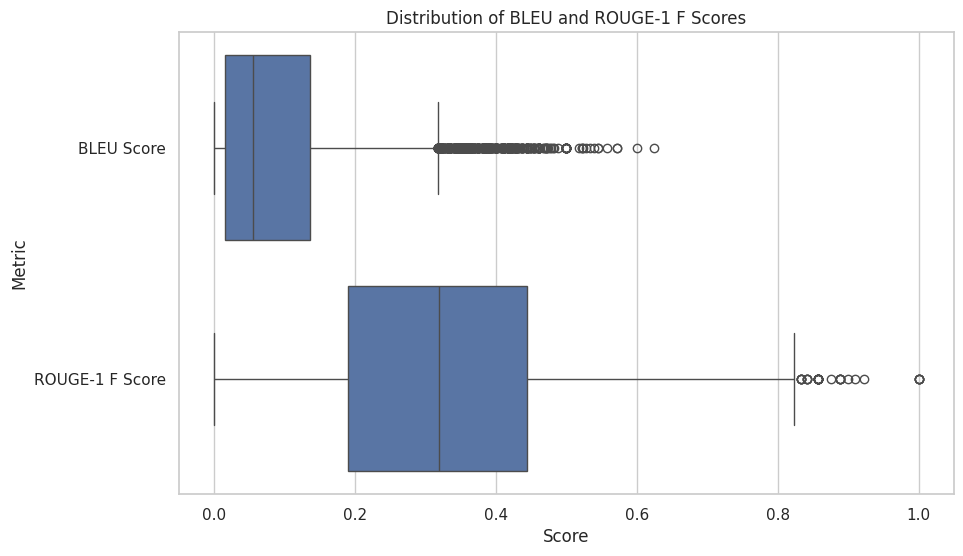

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

long_df = results_df.melt(value_vars=['BLEU Score', 'ROUGE-1 F Score'],
                          var_name='Metric', value_name='Score')

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(x='Score', y='Metric', data=long_df, orient='h')

plt.title('Distribution of BLEU and ROUGE-1 F Scores')
plt.xlabel('Score')
plt.ylabel('Metric')

# Display the plot
plt.show()

Initialize Wandb for tracking training and validation loss

In [ ]:
import wandb
import os

wandb.init(
    project="llama-finetuning",
    entity="kaushikmelch-new-york-university",
    config={
        "learning_rate": 2e-4,
        "per_device_train_batch_size": 4,
        "gradient_accumulation_steps": 32,
        "max_steps": 500,
        "warmup_steps": 40,
    }
)


wandb: Currently logged in as: kaushikmelch (kaushikmelch-new-york-university). Use `wandb login --relogin` to force relogin


In [ ]:
# Log final stats
wandb.log({"final_loss": trainer_stats.training_loss})

# Save and upload the model to WandB
trainer.save_model("outputs/llama_finetuned_model")
artifact = wandb.Artifact("llama_model", type="model")
artifact.add_dir("outputs")
wandb.log_artifact(artifact)

wandb: Adding directory to artifact (./outputs)... Done. 10.6s


<Artifact llama_model>